In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [40]:
(test, valid, train), info = tfds.load(
    name="tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True,
    with_info=True
)

2022-06-11 11:17:26.211531: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


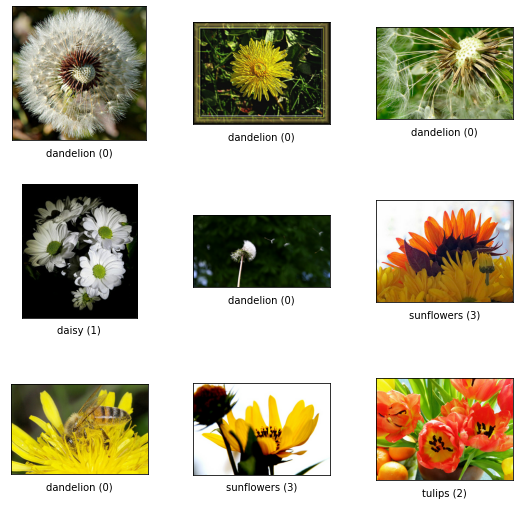

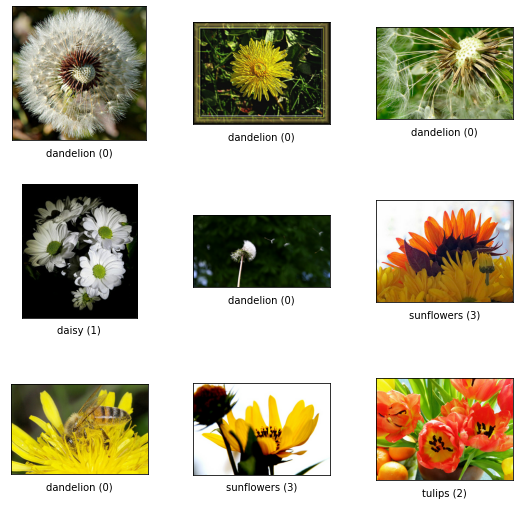

In [41]:
tfds.show_examples(train, info)

## Preprocess

In [74]:
num_test = info.splits["train[:10%]"].num_examples
num_valid = info.splits["train[10%:25%]"].num_examples
num_train = info.splits["train[25%:]"].num_examples

In [75]:
BATCH_SIZE = 64

In [76]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 127.5 - 1
    return image, label

In [77]:
train_batch = (
    train
        .shuffle(num_train // 4)
        .map(format_image)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
)
valid_batch = (
    valid
        .map(format_image)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
)
test_batch = (
    test
        .map(format_image)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
)

## Build the model

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import numpy as np

In [84]:
url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor_mn = hub.KerasLayer(url, input_shape=(224, 224, 3))

In [85]:
feature_extractor_mn.trainable  = False

In [100]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

In [101]:
model = Sequential([
    feature_extractor_mn,
    Dropout(0.5),
    Dense(info.features['label'].num_classes),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [102]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [103]:
!rm -rf tmp/checkpoints
!rm -rf logs

In [104]:
import datetime

EPOCHS = 6

log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_batch,
    epochs=EPOCHS,
    validation_data=valid_batch,
    callbacks=tensorboard_callback
)

Epoch 1/6
43/43 [==============================] - 46s 1s/step - loss: 1.3641 - accuracy: 0.5029 - val_loss: 0.6868 - val_accuracy: 0.7550
Epoch 2/6
43/43 [==============================] - 52s 1s/step - loss: 0.7352 - accuracy: 0.7286 - val_loss: 0.5563 - val_accuracy: 0.8058
Epoch 3/6
43/43 [==============================] - 55s 1s/step - loss: 0.5969 - accuracy: 0.7882 - val_loss: 0.4886 - val_accuracy: 0.8258
Epoch 4/6
43/43 [==============================] - 42s 972ms/step - loss: 0.5326 - accuracy: 0.8085 - val_loss: 0.4591 - val_accuracy: 0.8421
Epoch 5/6
43/43 [==============================] - 41s 960ms/step - loss: 0.4926 - accuracy: 0.8241 - val_loss: 0.4528 - val_accuracy: 0.8457
Epoch 6/6
43/43 [==============================] - 42s 975ms/step - loss: 0.4741 - accuracy: 0.8281 - val_loss: 0.4538 - val_accuracy: 0.8439


## Evaluate

In [91]:
import os
import sys

os.environ["TENSORBOARD_BINARY"] = os.path.join(
    os.path.dirname(sys.executable), 
    "tensorboard"
)

In [105]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [106]:
%tensorboard --logdir logs/fit